In [113]:
import pandas as pd
import numpy as np
from finance_ml.multiprocessing import mp_pandas_obj
from finance_ml.labeling import cusum_filter, get_t1, get_events, get_bins
from finance_ml.stats import get_daily_vol


df = pd.read_csv("../datasets/Google.csv")[:1000]
df.index = pd.DatetimeIndex(df['Date'].values)
close = df["Close"]

In [118]:
def get_rnd_t1(num_obs, num_bars, max_h):
    t1 = pd.Series()
    for i in xrange(num_obs):
        ix = np.random.randin(0, num_bars)
        val = ix + np.random.randint(1, max_h)
    return t1.sort_index()

In [119]:
def auxMC(num_obs, num_bars, max_h):
    t1 = get_rnd_t1(num_obs, num_bars, max_h)
    bar_idx = range(t1.max() + 1)
    ind_m = get_ind_matrix(bar_idx, t1)
    phi = np.random.choice(ind_m.columns, sizez=ind_m.shape[1])
    std_u = get_avg_uniquness(ind_m[phi]).mean()
    phi = seq_bootstrap(ind_m)
    seq_u = get_avg_uniquness(ind_m[phi]).mean()
    return {'std_u': std_u, 'seq_u': seq_u}

In [120]:
def mp_sample_w(t1, num_co_events, close, molecule):
    ret = np.log(close).diff()
    wght = pd.Series(index=molecule)
    for t_in, t_out in t1.loc[wght.index].iteritems():
        wght.loc[t_in] = (ret.loc[t_in:t_out] / num_co_events.loc[t_in:t_out]).sum()
    return wght.abs()

In [122]:
vol = get_daily_vol(close)
sampled_idx = cusum_filter(close, vol)
t1 = get_t1(close, sampled_idx, num_days=1)
trgt = vol
events = get_events(close, t_events=sampled_idx, trgt=trgt,
                       ptsl=1, t1=t1)
events.head()

/home/tom/anaconda3/lib/python3.6/site-packages/finance_ml-0.1-py3.6.egg/finance_ml/labeling/barriers.py:37: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
2018-06-30 17:12:05.200859 100.0% apply_ptslt1 done after 0.01 minutes. Remaining 0.0 minutes.


,t1,trgt,t1_type
2004-08-24,2004-08-25,0.036396,t1
2004-08-25,2004-08-26,0.029930,t1
2004-08-31,2004-09-01,0.026605,t1
2004-09-02,2004-09-03,0.024097,t1
2004-09-07,2004-09-08,0.023610,t1


# 4.1

In [141]:
vol = get_daily_vol(close)
sampled_idx = cusum_filter(close, vol)
t1 = get_t1(close, sampled_idx, num_days=5)
trgt = vol
events = get_events(close, t_events=sampled_idx, trgt=trgt,
                       ptsl=1, t1=t1)
events.head()

/home/tom/anaconda3/lib/python3.6/site-packages/finance_ml-0.1-py3.6.egg/finance_ml/labeling/barriers.py:37: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
2018-06-30 17:15:06.425237 100.0% apply_ptslt1 done after 0.01 minutes. Remaining 0.0 minutes.


,t1,trgt,t1_type
2004-08-24,2004-08-30,0.036396,t1
2004-08-25,2004-08-30,0.029930,sl
2004-08-31,2004-09-07,0.026605,t1
2004-09-02,2004-09-07,0.024097,t1
2004-09-07,2004-09-10,0.023610,pt


In [142]:
def get_num_co_events(close_idx, t1, molecule):
    # Find events that span the period defined by molecule
    t1 = t1.fillna(close_idx[-1])
    t1 = t1[t1 >= molecule[0]]
    t1 = t1.loc[:t1[molecule].max()]
    # Count the events
    iloc = close_idx.searchsorted(np.array([t1.index[0], t1.max()]))
    count = pd.Series(0, index=close_idx[iloc[0]: iloc[1] + 1])
    for t_in, t_out in t1.iteritems():
        count.loc[t_in: t_out] += 1
    return count.loc[molecule[0]: t1[molecule].max()]

In [143]:
num_threads = 24
num_co_events = mp_pandas_obj(get_num_co_events,
                              ('molecule', events.index),
                              num_threads,
                              close_idx=close.index,
                              t1=events['t1'])

# num_co_events = num_co_events.loc[~num_co_events.index.duplicated(keep='last')]
# num_co_events = num_co_events.reindex(close.index).fillna(0)

2018-06-30 17:15:06.930514 100.0% get_num_co_events done after 0.0 minutes. Remaining 0.0 minutes.


In [144]:
import matplotlib.pyplot as plt
%matplotlib inline

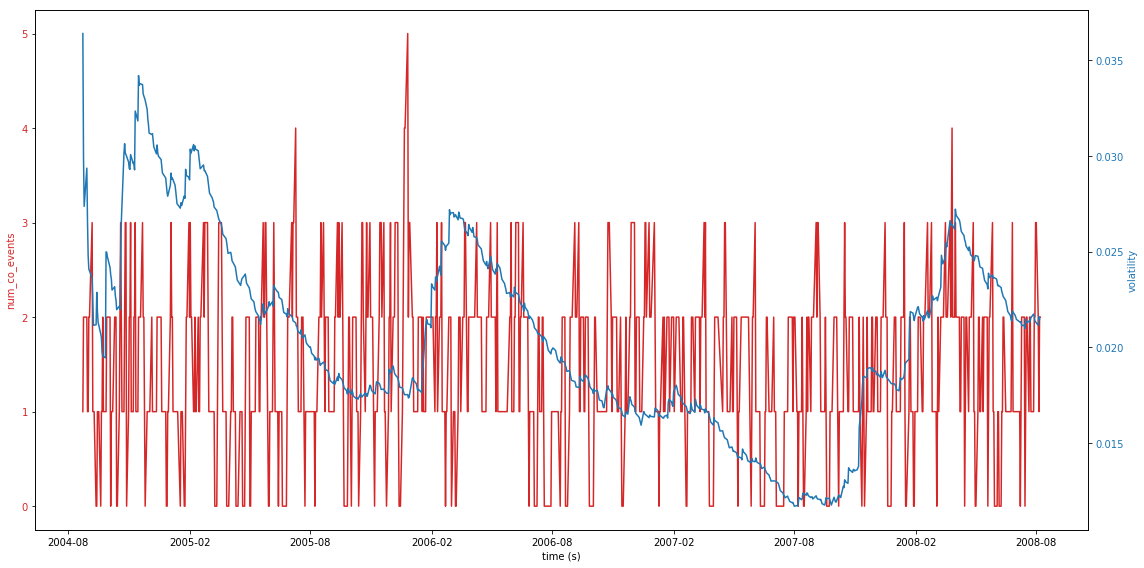

In [145]:
fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('num_co_events', color=color)
ax1.plot(num_co_events, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('volatility', color=color)  # we already handled the x-label with ax1
ax2.plot(vol, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

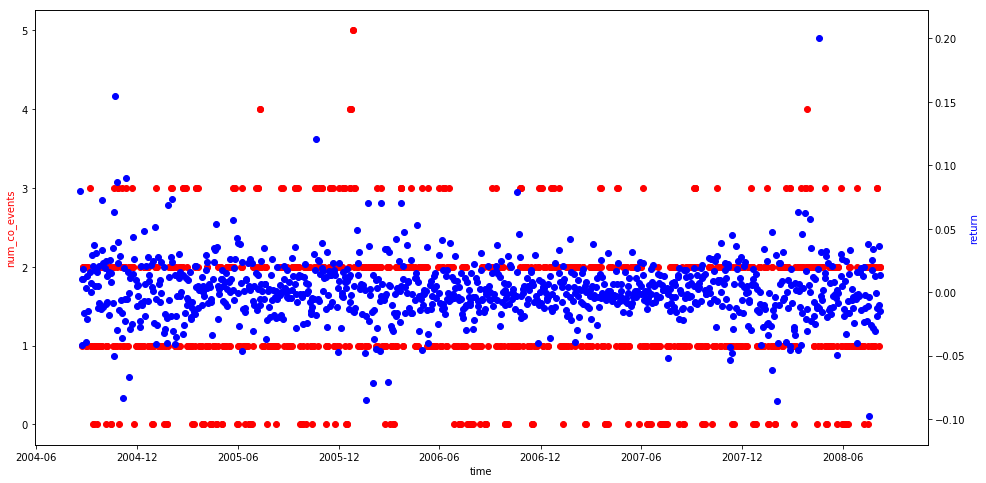

In [146]:
fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'red'
ax1.set_xlabel('time')
ax1.set_ylabel('num_co_events', color=color)
ax1.scatter(num_co_events.index, num_co_events.values, color=color)

ax2 = ax1.twinx()

color = 'blue'
ret = close.pct_change().dropna()
ax2.set_ylabel('return', color=color)
ax2.scatter(ret.index, ret.values, color=color)

# 4.2

In [329]:
def get_ind_matrix(bar_idx, t1):
    ind_m = pd.DataFrame(0, index=bar_idx,
                         columns=range(t1.shape[0]))
    for  i, (t0_, t1_) in enumerate(t1.iteritems()):
        ind_m.loc[t0_:t1_, i] = 1
    return ind_m

def get_avg_uniq(ind_m, c=None):
    if c is None:
        c = ind_m.sum(axis=1)
    ind_m = ind_m.loc[c > 0]
    c = c.loc[c > 0]
    u = ind_m.div(c, axis=0)
    avg_u = u[u>0].mean()
    avg_u = avg_u.fillna(0)
    return avg_u

In [330]:
ind_m = get_ind_matrix(close.index, events['t1'])
avg_uniq = get_avg_uniq(ind_m)
avg_uniq.head()

0    0.600000
1    0.500000
2    0.666667
3    0.444444
4    0.833333
dtype: float64

# 4.3

In [331]:
def seq_bootstrap(ind_m, s_length=None):
    if s_length is None:
        s_length = ind_m.shape[1]
    phi = []
    while len(phi) < s_length:
        c = ind_m[phi].sum(axis=1) + 1
        avg_u = get_avg_uniq(ind_m, c)
        prob = (avg_u / avg_u.sum()).values
        phi += [np.random.choice(ind_m.columns, p=prob)]
    return phi

In [335]:
phi = seq_bootstrap(ind_m)
print(phi)

[41, 267, 201, 37, 391, 312, 321, 326, 124, 289, 310, 109, 366, 97, 251, 16, 409, 328, 378, 237, 84, 108, 412, 10, 24, 67, 58, 193, 78, 53, 171, 73, 388, 403, 294, 141, 42, 208, 263, 270, 48, 319, 303, 46, 232, 395, 202, 345, 230, 56, 89, 226, 272, 198, 363, 164, 292, 41, 136, 256, 383, 122, 209, 71, 191, 119, 401, 294, 53, 61, 206, 307, 252, 302, 251, 395, 240, 336, 321, 187, 306, 398, 107, 280, 8, 351, 219, 154, 394, 387, 82, 44, 39, 351, 9, 59, 299, 399, 139, 405, 397, 105, 318, 304, 227, 32, 54, 183, 63, 119, 267, 342, 327, 118, 60, 8, 16, 31, 330, 291, 404, 214, 145, 87, 234, 165, 417, 228, 66, 172, 220, 242, 332, 333, 72, 263, 195, 157, 51, 348, 178, 328, 195, 344, 291, 176, 62, 2, 211, 387, 169, 167, 189, 288, 21, 379, 361, 124, 349, 180, 19, 111, 4, 348, 146, 245, 382, 275, 308, 99, 382, 337, 352, 326, 249, 94, 279, 126, 367, 238, 370, 353, 336, 253, 301, 225, 295, 64, 130, 30, 383, 85, 87, 352, 115, 277, 147, 91, 329, 144, 50, 193, 402, 269, 324, 385, 71, 229, 107, 342, 151, 3

# 4.4

In [337]:
vol = get_daily_vol(close)
sampled_idx = cusum_filter(close, vol)
t1 = get_t1(close, sampled_idx, num_days=1)
trgt = vol
events = get_events(close, t_events=sampled_idx, trgt=trgt,
                       ptsl=1, t1=t1)
events.head()

/home/tom/anaconda3/lib/python3.6/site-packages/finance_ml-0.1-py3.6.egg/finance_ml/labeling/barriers.py:37: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
2018-06-30 19:30:36.596433 100.0% apply_ptslt1 done after 0.01 minutes. Remaining 0.0 minutes.


,t1,trgt,t1_type
2004-08-24,2004-08-25,0.036396,t1
2004-08-25,2004-08-26,0.029930,t1
2004-08-31,2004-09-01,0.026605,t1
2004-09-02,2004-09-03,0.024097,t1
2004-09-07,2004-09-08,0.023610,t1


In [339]:
num_threads = 24
num_co_events = mp_pandas_obj(mp_num_co_events,
                              ('molecule', events.index),
                              num_threads,
                              close_idx=close.index,
                              t1=events['t1'])

num_co_events = num_co_events.loc[~num_co_events.index.duplicated(keep='last')]
num_co_events = num_co_events.reindex(close.index).fillna(0)
tw = mp_pandas_obj(get_sample_tw,
                   ('molecule', events.index),
                   num_threads,
                   t1=events['t1'],
                   num_co_events=num_co_events)

2018-06-30 19:33:09.625546 100.0% mp_num_co_events done after 0.0 minutes. Remaining 0.0 minutes.
2018-06-30 19:33:10.141670 100.0% get_sample_tw done after 0.0 minutes. Remaining 0.0 minutes.


In [367]:
def get_time_decay(tw, last_w=1., truncate=0, is_exp=False):
    cum_w = tw.sort_index().cumsum()
    init_w = 1.
    if is_exp:
        init_w = np.log(init_w)
    if last_w >= 0:
        if is_exp:
            last_w = np.log(last_w)
        slope = (init_w - last_w) / cum_w.iloc[-1]
    else:
        slope = init_w / ((last_w + 1) * cum_w.iloc[-1])
    const = init_w - slope * cum_w.iloc[-1]
    weights = const + slope * cum_w
    if is_exp:
        weights =np.exp(weights)
    weights[weights < truncate] = 0
    return weights

def get_sample_tw(t1, num_co_events, molecule):
    wght = pd.Series(index=molecule)
    for t_in, t_out in t1.loc[wght.index].iteritems():
        wght.loc[t_in] = (1. / num_co_events.loc[t_in: t_out]).mean()
    return wght

In [368]:
exp_decay = get_time_decay(tw, last_w=.1, is_exp=True)
exp_decay.head()

2004-08-24    0.100521
2004-08-25    0.101044
2004-08-31    0.101746
2004-09-02    0.102453
2004-09-07    0.103165
dtype: float64

In [364]:
np.clip(-3, 0, None)

0